In [1]:
import os
import pandas as pd
import numpy as np
import time
from collections import Counter
import bz2
import re
import matplotlib.pyplot as plt
import seaborn as sns

import utils

In [2]:
def get_words(string):
    # Make all lower-case.
    string = string.lower()
    
    # Remove punctuation.
    string = re.sub(r'[^a-z0-9 ]', '', string)
    
    # Split into words.
    words = string.split()
    
    return words

In [3]:
def process_files(data_dir, output_file_path, can_reuse_output = True):
    if os.path.isfile(output_file_path) and can_reuse_output:
        return
    
    filenames = [filename for filename in os.listdir(data_dir) if filename.endswith('.json.bz2')]
    input_files_paths = [os.path.join(data_dir, filename) for filename in filenames]

    domain_matcher = re.compile(r"^(?:https?:\/\/)?(?:[^@\/\n]+@)?(?:www\.)?(?P<domain>[^:\/?\n]+)")
    get_domain_from_url = lambda url: domain_matcher.match(url).group('domain')
    
    processing_function = lambda line: {'quote_word_count': Counter(get_words(line['quotation'])),
                                        'speaker'         : line['speaker'],
                                        'qids'            : line['qids'],
                                        'first_date'      : line['date'],
                                        'num_occurrences' : line['numOccurrences'],
                                        'domains'         : [get_domain_from_url(url) for url in line['urls']]}
    
    with bz2.open(output_file_path, 'wb') as output_file:
        for input_file_path in input_files_paths:
            utils.process_json_file_per_line(input_file_path, processing_function, output_file)

In [4]:
DATA_DIR = 'Data'
CACHE_DIR = 'Cache'
SPEAKER_INFO_FILE_PATH = os.path.join(DATA_DIR, 'speaker_attributes.parquet')
CACHE_FILE_PATH = os.path.join(CACHE_DIR, 'processed_data.json.bz2')

process_files(DATA_DIR, CACHE_FILE_PATH)

### What is a Viral Quote?

In [5]:
@utils.cache_to_file_pickle("function-get_num_occurrences", cache_dir = CACHE_DIR, ignore_kwargs = ["print_progress_every"])
def get_num_occurrences(input_file_path, print_progress_every):
    return process_json_file_per_line(input_file_path, 
                                      lambda x: x['num_occurrences'], 
                                      return_processed_lines_list = True,
                                      print_progress_every = print_progress_every)


num_occurrences = get_num_occurrences(input_file_path = CACHE_FILE_PATH)
num_occurrences = np.array(num_occurrences)

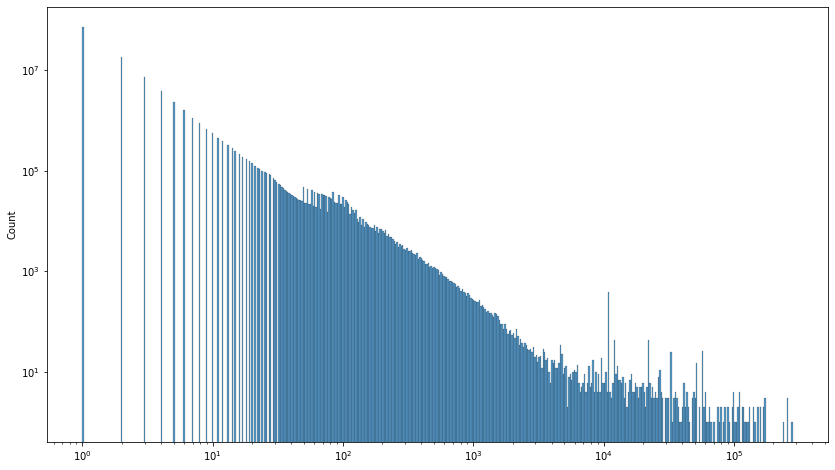

In [6]:
plt.figure(figsize = (14, 8))
sns.histplot(num_occurrences, bins = 500, log_scale = (True, True));

#### IT'S A POWER LAW (MAYBE)!

In [7]:
pd.Series(num_occurrences).describe(percentiles = [0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 0.999]).apply(int)

count    115584257
mean             3
std            113
min              1
50%              1
95%             10
96%             13
97%             17
98%             26
99%             55
99.5%           90
99.9%          215
max         282552
dtype: int64

In [8]:
viral_thr = 100

print(f"{np.mean(num_occurrences < viral_thr):.3%} of quotes are quoted less than {viral_thr} times")
print(f"Quotes cited {viral_thr} times or more:", np.sum(num_occurrences >= viral_thr))
print(f"Quotes cited less than {viral_thr} times:", np.sum(num_occurrences < viral_thr))

99.587% of quotes are quoted less than 100 times
Quotes cited 100 times or more: 477879
Quotes cited less than 100 times: 115106378


### Extract Speaker Information

In [ ]:
# OTHER JUPYTER

# POUR KAOU

Bonjour Kaou, tu as choisi word counting. Si tu n'as pas lu ça assez tôt, j'ai déjà eu le temps de relancer la cellule du haut et enlever la punctuation plus mettre tous les mots en minuscule pour toi.

Lis cette page pour des idées sur comment faire évoluer ton travail au délà du word counting: https://scikit-learn.org/stable/modules/feature_extraction.html

Je te mets aussi à disposition une simple fonction qui efface les "English stop words" d'une liste de mots. Par contre, fais gaffe à comment tu l'utilises. Les stop words ne sont pas nécéssairement toutes toujours inutiles. Lis sklearn pour les détails et affiche la liste avant d'utiliser la fonction pour voir si elle t'arrange. Tu peux covertir la fonction pour qu'elle droppe le compte des stop words dans un compteur en faisant del counter_object[word].

In [1]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def remove_stopwords(word_list):
    return [word for word in word_list if word not in ENGLISH_STOP_WORDS]

# POUR CÉLINA

Coucou CC, il nous ont donné un file .parquet (juste un autre format de stockage binaire, un peux comme pickle) que normalement j'ai mis dans le dossier Data. Il devrait contenir plusieures informations sur chaque speaker. Tu peux le load comme ça, mais il me semble qu'il faut installer pyarrow (  conda install -c conda-forge pyarrow  ).

Malheureusement il parait qu'ils aient utilisé le QID de Wikidata pour encoder la profession, religion et tout le reste. Probablement une des première choses à faire est de trouver un moyen de mapper les QIDS à des string, que je sais faire en faisant des queries à wikidata mais je me demande s'il n'y a pas un moyen plus simple. Au pire on le fait (que une fois de toute façon).

Il faudrait aussi s'assurer que dans le parquet qu'ils nous donnent il n'y ait pas que peu d'occupations au bol, mais un grand nombre comme celui qu'on voit sur wikidata, car autrement on a le même problème que quand je faisais les queries (que j'ai découvert comment resudre) qui est que pour des gens avec beaucoup de professions on en avait seulement 3 au bol.

Oubliepas que je t'ai dit qu'il y a un problème avec l'antivirus et la lecture de .json. Je ne sais pas pourquoi, mais à chaque fois que tu veux commencer à lire un json tu dois mettre en standby l'anti-virus pendant une minute. C'est assez chiant, mais je n'ai pas trouvé d'autre solution (sinon, le programme ne plante pas, il s'arrete juste et ne dit rien et attend jusqu'à que tu desactives).

Pour le moment c'est tout je crois.

- Cas quand plusieurs qids par quote, lequel on prend ? (je sais pas s'il y a moyen de savoir laquelle est la plus populaire, peut-être celle qui a le plus de liens externes)

# POUR ANDREA
Bonjour Andrea, ça va? Oui très bien, merci. J'essaye de poser une base pour commencer le Milestone 2 du projet. Et toi? Moi aussi, drôle ça. Bon, à toute. Bon travail, à toute.

Il faut rerun la lecture du dataset avec la remotion de ponctuation.

Je suppose que tu vas faire la partie de correler les dates à des événements, et si t'as envie d'essayer d'extraire la variance. Par contre pour le moment je ne sais pas trop comment ça colle avec le reste de l'analyse. Dans le sens que la data story va parler de quoi concernant les dates?

# POUR MATTIA
Buongiorno Mattia, je suppose que tu vas faire la partie de regarder les newspapers et correler avec les speakers et, si on arrive, l'argument de la quote. Pour toi je crois que juste load le processed_data.json.bz2 et garder que les clés 'domains' et 'speaker' devrait le faire. Il faudra sûrement se coordonner avec Célina et Kaou pour voir justement comment correler les trucs. Pour le moment, je t'avoue que comme pour ma partie, je n'ai pas une idéé précide de comment ceci va coller dans une data story coherente. Faudra que Kaou et Célina avancent rapidement pour que tu puisse commencer à repliquer leur travail mais pour différents newspapers. Ou je ne sais pas. Faudra juste pas qu'on reste bloqués si on attend quelqu'un d'autre.